In [6]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from operator import itemgetter

In [7]:
with open('./data/autori_cleaned', 'rb') as file:
    autori = pd.read_pickle(file)
with open('./data/data_cleaned', 'rb') as file:
    data = pd.read_pickle(file)

In [8]:
print(autori.head())
print(data.head())

          Ime            Prezime                    Katedra  H indeks  \
0       tanja          jovanovic  katedra za mikrobiologiju        11   
1  branislava              savic  katedra za mikrobiologiju        10   
2       sanja           mitrovic  katedra za mikrobiologiju         4   
3       lazar              ranin  katedra za mikrobiologiju         7   
4   valentina  arsic-arsenijevic  katedra za mikrobiologiju        17   

   Broj radova  id                     Puno ime              Skraceno  
0           45   0              tanja jovanovic          jovanovic t.  
1           30   1             branislava savic              savic b.  
2           20   2               sanja mitrovic           mitrovic s.  
3           40   3                  lazar ranin              ranin l.  
4           52   4  valentina arsic-arsenijevic  arsic-arsenijevic v.  
                    Author                                              Title  \
0  jasmina simonovic-babic  state of viral hepat

In [9]:
G = nx.Graph()
for _,row in autori.iterrows():
    G.add_node(row['Puno ime'], katedra=row['Katedra'])

In [14]:
from itertools import combinations

title_grouped = data.groupby('Title')['Author']
for _,authors in title_grouped:
    author_list = authors.tolist()
    author_pairs = combinations(author_list,2)
    for autor1,autor2 in author_pairs:
        if (autor1, autor2) in G.edges:
            G.edges[autor1,autor2]['weight'] += 1
        else:
            G.add_edge(autor1, autor2, weight=1)

In [16]:
output_path="models/undirected_papper_colaboration.gml"
nx.write_gml(G, output_path)

In [18]:
# Calculate density
density = nx.density(G)
print(f'Network Density: {density}')

Network Density: 0.1748911465892598


In [20]:
avg_distance = nx.average_shortest_path_length(G)
print(f'Average Distance: {avg_distance}')

Average Distance: 2.3570391872278664


In [22]:
diameter = nx.diameter(G)
print(f'Diameter: {diameter}')

Diameter: 5


In [24]:
if nx.is_connected(G):
    num_components = 1
    component_sizes = [len(G.nodes)]
else:
    components = list(nx.connected_components(G))
    num_components = len(components)
    component_sizes = [len(component) for component in components]

print(f'Number of Connected Components: {num_components}')
print(f'Size of Each Component: {component_sizes}')

Number of Connected Components: 1
Size of Each Component: [53]


Imam jednu dzinovsku komponentu?

In [27]:
def calculate_centralities(G):

    DC_dict = nx.degree_centrality(G)
    CC_dict = nx.closeness_centrality(G)
    BC_dict = nx.betweenness_centrality(G)
    EVC_dict = nx.eigenvector_centrality(G)

    df1 = pd.DataFrame.from_dict(DC_dict, orient='index', columns=['DC'])
    df2 = pd.DataFrame.from_dict(CC_dict, orient='index', columns=['CC'])
    df3 = pd.DataFrame.from_dict(BC_dict, orient='index', columns=['BC'])
    df4 = pd.DataFrame.from_dict(EVC_dict, orient='index', columns=['EVC'])
    df = pd.concat([df1, df2, df3, df4], axis=1)
    return df

In [28]:
df = calculate_centralities(G)
print(df.head(5))
print(f'Centralnost sortirana po DC: \n {df.sort_values(['DC'], ascending=False).head(5)}')
print(f'Centralnost sortirana po CC:  \n {df.sort_values(['CC'], ascending=False).head(5)}')
print(f'Centralnost sortirana po BC: \n {df.sort_values(['BC'], ascending=False).head(5)}')
print(f'Centralnost sortirana po EVC: \n {df.sort_values(['EVC'], ascending=False).head(5)}')

                                   DC        CC        BC       EVC
tanja jovanovic              0.192308  0.504854  0.028419  0.141412
branislava savic             0.134615  0.400000  0.007689  0.053655
sanja mitrovic               0.153846  0.452174  0.057838  0.044523
lazar ranin                  0.230769  0.440678  0.058853  0.100766
valentina arsic-arsenijevic  0.134615  0.444444  0.032813  0.044053
Centralnost sortirana po DC: 
                         DC        CC        BC       EVC
ivana lazarevic   0.365385  0.553191  0.171774  0.303525
goran stevanovic  0.288462  0.509804  0.066559  0.265913
maja cupic        0.288462  0.514851  0.065122  0.184637
vera mijac        0.269231  0.500000  0.073322  0.120571
milos korac       0.269231  0.485981  0.046700  0.265604
Centralnost sortirana po CC:  
                            DC        CC        BC       EVC
ivana lazarevic      0.365385  0.553191  0.171774  0.303525
aleksandra knezevic  0.192308  0.514851  0.030857  0.137538
maja cu

In [31]:
def centralizationGraph(G):
    centralities = nx.degree_centrality(G)
    star_centralities = nx.degree_centrality(nx.star_graph(len(G.nodes)))
    max_centrality = max(centralities.values())
    max_centrality_star = max(star_centralities.values())
    centralization = sum(max_centrality - c for c in centralities.values()) / sum(max_centrality_star - c for c in star_centralities.values())
    return centralization
centralization_value = centralizationGraph(G)
print(f'Centralization: {centralization_value:.4f}')


Centralization: 0.1942


In [32]:
global_clustering_coefficient = nx.transitivity(G)
print(f'Global Clustering Coefficient (Transitivity): {global_clustering_coefficient}')

average_clustering_coefficient = nx.average_clustering(G)
print(f'Average Clustering Coefficient: {average_clustering_coefficient}')

local_clustering_coefficients = nx.clustering(G).values()


Global Clustering Coefficient (Transitivity): 0.5450928381962865
Average Clustering Coefficient: 0.6005288212835382


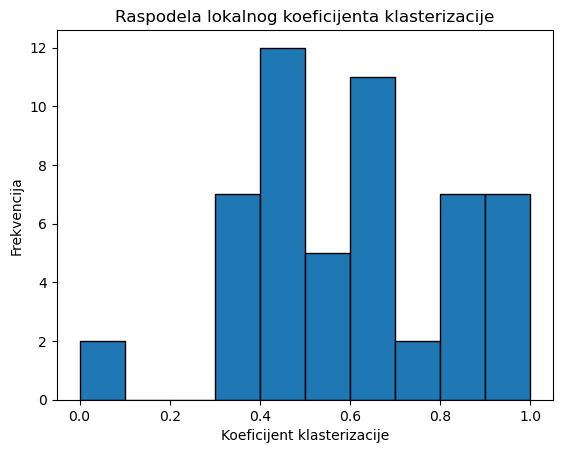

In [35]:
# 2. Plot the distribution of local clustering coefficients
plt.hist(local_clustering_coefficients, bins=10, edgecolor='black')
plt.title('Raspodela lokalnog koeficijenta klasterizacije')
plt.xlabel('Koeficijent klasterizacije')
plt.ylabel('Frekvencija')
plt.savefig('koeficijent_klasterizacije.png')
plt.show()

In [36]:
# Erdos-Renyi Random Graph
n = G.number_of_nodes()
p = nx.density(G)  
G_erdos = nx.erdos_renyi_graph(n, p)

In [37]:
# Scale-Free Network
G_scale_free_multi = nx.scale_free_graph(n,alpha=0.12, beta=0.80, gamma = 0.08)
G_scale_free = nx.Graph(G_scale_free_multi)

In [38]:
# Calculate clustering coefficients for comparison
average_clustering_erdos = nx.average_clustering(G_erdos)
average_clustering_scale_free = nx.average_clustering(G_scale_free)
transitivity_erdos = nx.transitivity(G_erdos)
transitivity_scale_free = nx.transitivity(G_scale_free)

print(f'Erdos-Renyi Average Clustering Coefficient: {average_clustering_erdos}')
print(f'Erdos-Renyi Global Clustering Coefficient: {transitivity_erdos}')
print(f'Scale-Free Average Clustering Coefficient: {average_clustering_scale_free}')
print(f'Scale-Free Global Clustering Coefficient: {transitivity_scale_free}')

Erdos-Renyi Average Clustering Coefficient: 0.16915803705481838
Erdos-Renyi Global Clustering Coefficient: 0.17504488330341114
Scale-Free Average Clustering Coefficient: 0.33496146312839
Scale-Free Global Clustering Coefficient: 0.13548387096774195


In [39]:
print(len(G_scale_free.edges))

89


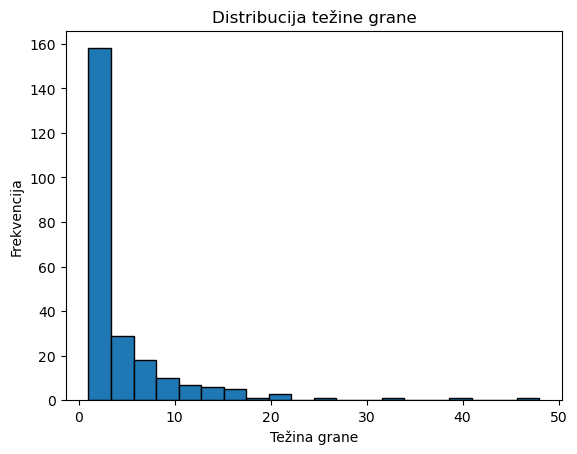

In [43]:
# 1. Edge Weight Distribution
weights = [data['weight'] for u, v, data in G.edges(data=True)]
plt.hist(weights, bins=20, edgecolor='black')
plt.title('Distribucija težine grane')
plt.xlabel('Težina grane')
plt.ylabel('Frekvencija')
plt.savefig('distribucija-tezine-grane.png')
plt.show()


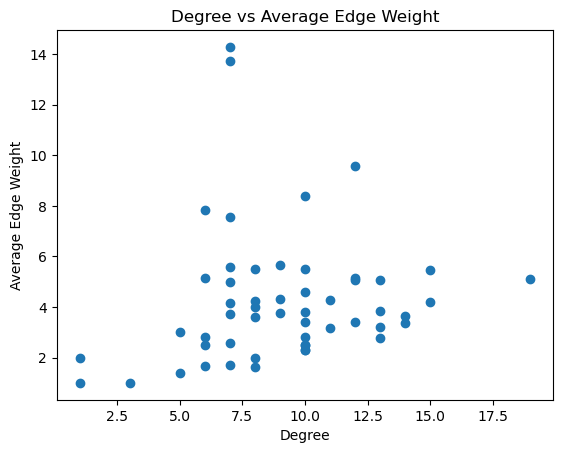

In [46]:
# 2. Degree vs. Average Edge Weight  vidi sto ti ovo po stepenu???
degrees = dict(G.degree())
strengths = dict(G.degree(weight='weight'))
avg_edge_weights = {node: strengths[node] / degrees[node] for node in G.nodes()}
plt.scatter(degrees.values(), avg_edge_weights.values())
plt.title('Degree vs Average Edge Weight')
plt.xlabel('Degree')
plt.ylabel('Average Edge Weight')
plt.show()


In [47]:
assortativity_coefficient = nx.degree_assortativity_coefficient(G)
print(f'Degree Assortativity Coefficient: {assortativity_coefficient}')

Degree Assortativity Coefficient: 0.04567166142802434


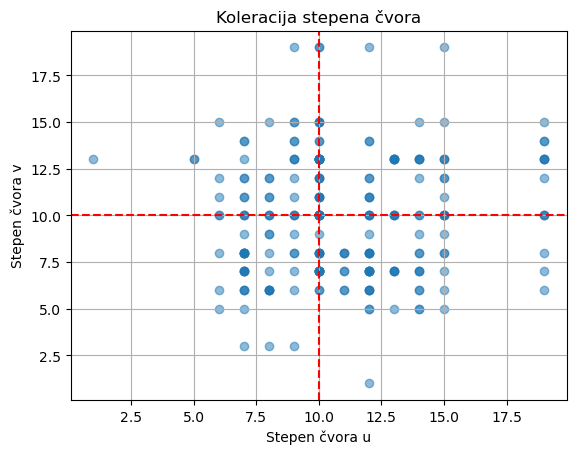

In [48]:
degrees = dict(G.degree())
x, y = zip(*[(degrees[u], degrees[v]) for u, v in G.edges()])

plt.scatter(x, y, alpha=0.5)
plt.axvline(x=10, color='red', linestyle='--')
plt.axhline(y=10, color='red', linestyle='--')
plt.title('Koleracija stepena čvora')
plt.xlabel('Stepen čvora u')
plt.ylabel('Stepen čvora v')
plt.grid(True)
plt.savefig('koleracija-stepena-cvora.png')
plt.show()

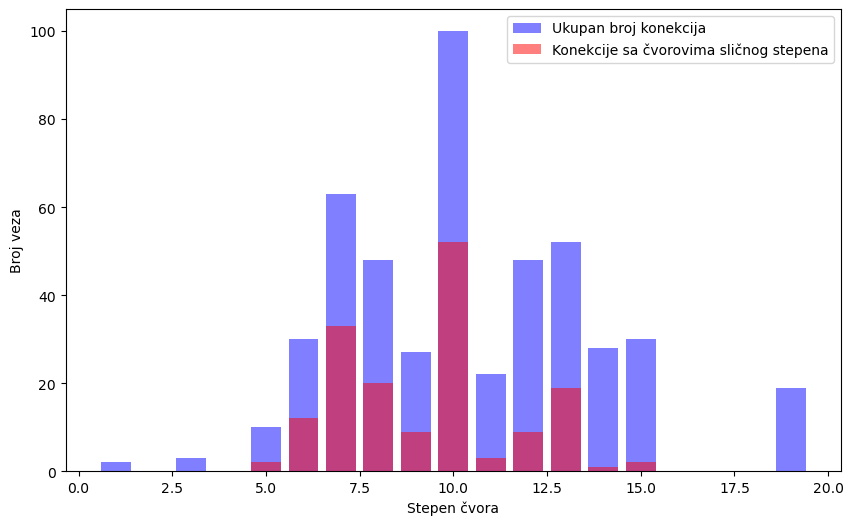

In [49]:
from collections import defaultdict

edges_per_degree = defaultdict(int)
higher_or_equal_edges_per_degree = defaultdict(int)

for u, v in G.edges():
    degree_u = degrees[u]
    degree_v = degrees[v]
    
    edges_per_degree[degree_u] += 1
    edges_per_degree[degree_v] += 1
    
    if degree_v >= degree_u and degree_v - 3 <= degree_u:
        higher_or_equal_edges_per_degree[degree_u] += 1
    if degree_u >= degree_v and degree_u - 3 <= degree_v:
        higher_or_equal_edges_per_degree[degree_v] += 1

sorted_degrees = sorted(edges_per_degree.keys())
total_edges = [edges_per_degree[d] for d in sorted_degrees]
higher_or_equal_edges = [higher_or_equal_edges_per_degree[d] for d in sorted_degrees]

plt.figure(figsize=(10, 6))
plt.bar(sorted_degrees, total_edges, alpha=0.5, label='Ukupan broj konekcija', color='blue')
plt.bar(sorted_degrees, higher_or_equal_edges, alpha=0.5, label='Konekcije sa čvorovima sličnog stepena', color='red')
plt.xlabel('Stepen čvora')
plt.ylabel('Broj veza')
plt.legend()
plt.savefig('asortivnost-po-cvoru.png')

plt.show()

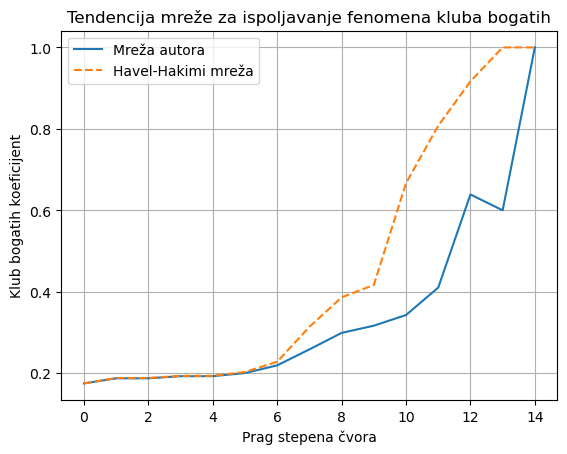

In [51]:
rich_club_coefficient_original = nx.rich_club_coefficient(G, normalized=False)

degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
G_havel_hakimi = nx.havel_hakimi_graph(degree_sequence)
rich_club_coefficient_havel_hakimi = nx.rich_club_coefficient(G_havel_hakimi, normalized=False)


degrees = sorted(set(rich_club_coefficient_original.keys()) & set(rich_club_coefficient_havel_hakimi.keys()))

original_values = [rich_club_coefficient_original[d] for d in degrees]
havel_hakimi_values = [rich_club_coefficient_havel_hakimi[d] for d in degrees]

plt.plot(degrees, original_values, label='Mreža autora')
plt.plot(degrees, havel_hakimi_values, label='Havel-Hakimi mreža', linestyle='--')
plt.xlabel('Prag stepena čvora')
plt.ylabel('Klub bogatih koeficijent')
plt.title('Tendencija mreže za ispoljavanje fenomena kluba bogatih')
plt.legend()
plt.grid(True)
plt.savefig('rich-club-plot.png')
plt.show()


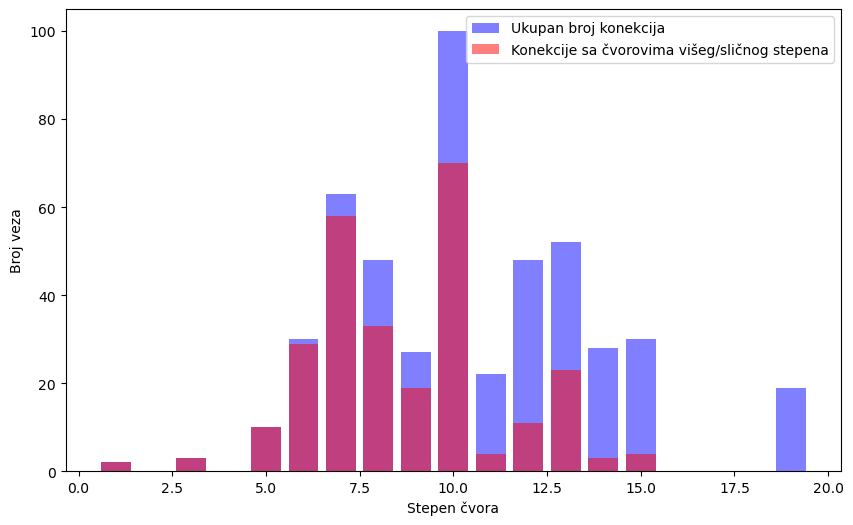

In [55]:
degrees = dict(G.degree())

edges_per_degree = defaultdict(int)
higher_or_equal_edges_per_degree = defaultdict(int)

for u, v in G.edges():
    degree_u = degrees[u]
    degree_v = degrees[v]
    
    edges_per_degree[degree_u] += 1
    edges_per_degree[degree_v] += 1
    
    if degree_v >= degree_u:
        higher_or_equal_edges_per_degree[degree_u] += 1
    if degree_u >= degree_v:
        higher_or_equal_edges_per_degree[degree_v] += 1

sorted_degrees = sorted(edges_per_degree.keys())
total_edges = [edges_per_degree[d] for d in sorted_degrees]
higher_or_equal_edges = [higher_or_equal_edges_per_degree[d] for d in sorted_degrees]

plt.figure(figsize=(10, 6))
plt.bar(sorted_degrees, total_edges, alpha=0.5, label='Ukupan broj konekcija', color='blue')
plt.bar(sorted_degrees, higher_or_equal_edges, alpha=0.5, label='Konekcije sa čvorovima višeg/sličnog stepena', color='red')
plt.xlabel('Stepen čvora')
plt.ylabel('Broj veza')
plt.legend()
plt.savefig('ruch-club-bar-plot.png')

plt.show()

In [57]:
# 1. Calculate degree sequence
degree_sequence = [d for n, d in G.degree()]
degree_count = np.bincount(degree_sequence)
degrees = np.arange(len(degree_count))
print('degrees: ', degrees)
print('degree_count: ', degree_count)


degrees:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
degree_count:  [ 0  2  0  1  0  2  5  9  6  3 10  2  4  4  2  2  0  0  0  1]


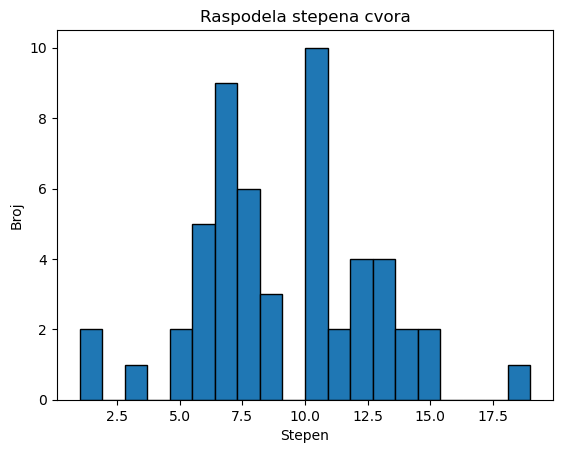

In [58]:
plt.hist(degree_sequence, bins=20, edgecolor='black')
plt.title('Raspodela stepena cvora')
plt.xlabel('Stepen')
plt.ylabel('Broj')
plt.show()


In [60]:
import powerlaw

Calculating best minimal value for power law fit
C:\Users\and\anaconda3\Lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


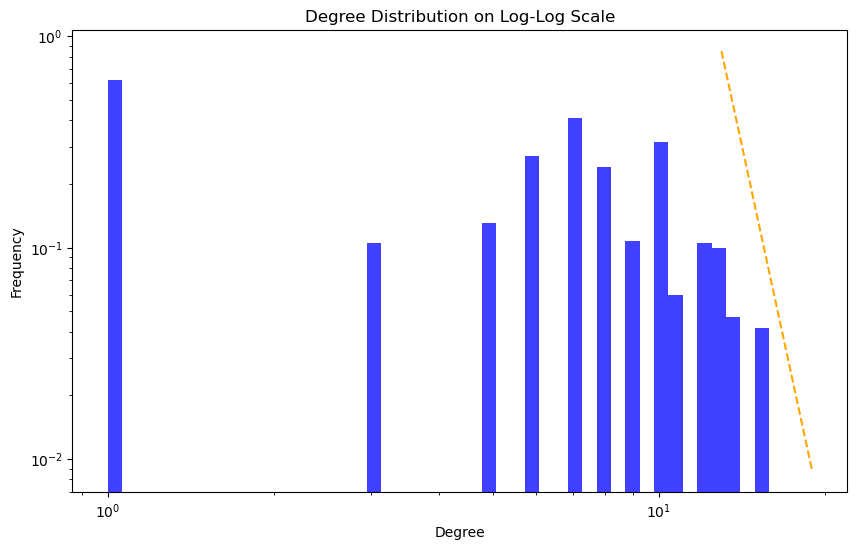

Alpha (exponent of power-law): 12.057770972772497
Log-likelihood of power-law fit: 13.0
KS test for power-law fit: 0.12784712396392073
Log-likelihood ratio R: 0.31888810786889676
p-value for power-law vs. exponential: 0.24441031672802271


C:\Users\and\anaconda3\Lib\site-packages\powerlaw.py:1605: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


In [73]:
degrees = [d for n, d in G.degree()]

# Step 2: Fit a power-law distribution to the degree data
fit = powerlaw.Fit(degrees)

# Step 3: Plot the degree distribution on a log-log scale
plt.figure(figsize=(10, 6))
#plt.hist(degrees, bins=np.logspace(np.log10(1), np.log10(max(degrees)), num=50), density=True)
degree_counts, bin_edges, _ = plt.hist(degrees, bins=np.logspace(np.log10(1), np.log10(max(degrees)), num=50), density=True, alpha=0.75, color='blue')

# Plot the power-law fit
fit.power_law.plot_pdf(color='orange', linestyle='--', label=f'Power-law fit (alpha={fit.alpha:.2f})')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution on Log-Log Scale')
plt.show()

# Step 4: Print the alpha value and the goodness of fit
print(f"Alpha (exponent of power-law): {fit.alpha}")
print(f"Log-likelihood of power-law fit: {fit.power_law.xmin}")
R, p = fit.distribution_compare('power_law', 'lognormal')
print(f"KS test for power-law fit: {fit.power_law.KS()}")

# Step 5: Compare with other distributions (optional)
R, p = fit.distribution_compare('power_law', 'exponential')
print(f"Log-likelihood ratio R: {R}")
print(f"p-value for power-law vs. exponential: {p}")

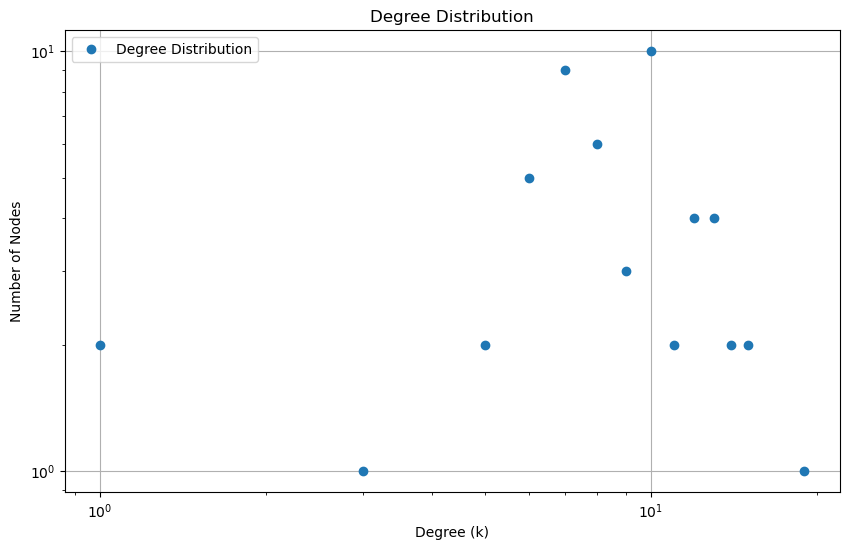

In [58]:
plt.figure(figsize=(10, 6))
plt.loglog(degrees, degree_count, marker='o', linestyle='None', label='Degree Distribution')
plt.title("Degree Distribution")
plt.xlabel("Degree (k)")
plt.ylabel("Number of Nodes")
plt.legend()
plt.grid(True)
plt.show()